In [76]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_20_with_tiers.csv')
df = df[df['round'] == 'First Round']
print(df.shape)
df.head()

(638, 73)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,kenpom_adjem,kenpom_adjoe,...,D_B,D_C,D_D,D_F,F_S,F_A,F_B,F_C,F_D,F_F
0,2004,East,First Round,1,2004 Saint Joseph's,16,2004 Liberty,1,30.5129,89.1570,...,0,0,0,0,0,0,0,0,0,0
7,2004,East,First Round,8,2004 Texas Tech,9,2004 Charlotte,1,1.4368,78.2630,...,0,0,0,0,0,0,0,0,0,0
8,2004,East,First Round,5,2004 Florida,12,2004 Manhattan,0,8.3076,83.7144,...,0,0,0,0,0,0,0,0,0,0
9,2004,East,First Round,4,2004 Wake Forest,13,2004 VCU,1,13.6345,86.9167,...,0,0,0,0,0,0,0,0,0,0
10,2004,East,First Round,6,2004 Wisconsin,11,2004 Richmond,1,9.5954,74.4991,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df['win'].value_counts(normalize=True)

1   0.7257
0   0.2743
Name: win, dtype: float64

In [78]:
eda_df = df[[
'win',
 'kenpom_adjem',
 'kenpom_adjoe',
 'kenpom_adjde',
 'off_efg_pct',
 'def_efg_pct',
 'def_to_pct',
 'off_2pt_pct',
 'off_3pt_pct',
 'def_block_pct',
 'off_stl_rate',
 'def_ast_rate',
 'def_stl_rate',
 'S_D',
 'S_F',
 'A_D',
 'A_F',
 'C_B',
 'C_C']]  

In [79]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((446, 18), (192, 18))

### I. Lasso Regression

In [80]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [81]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [82]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 18
selected features: 14
features with coefficients shrank to zero: 4


In [83]:
selected_feat

Index(['kenpom_adjem', 'kenpom_adjoe', 'def_to_pct', 'off_2pt_pct',
       'off_3pt_pct', 'def_block_pct', 'off_stl_rate', 'def_ast_rate',
       'def_stl_rate', 'S_D', 'S_F', 'A_F', 'C_B', 'C_C'],
      dtype='object')

## II. Backward Selection

In [84]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [85]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [86]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['kenpom_adjoe', 'kenpom_adjde', 'def_to_pct', 'off_2pt_pct',
       'off_3pt_pct', 'off_stl_rate', 'def_ast_rate', 'def_stl_rate',
       'A_F', 'C_B'], dtype=object)

In [87]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8928238817991895
Test set
Random Forests roc-auc: 0.7181318681318681


In [88]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8786780437463818
Test set
Random Forests roc-auc: 0.7347527472527473


### III. Forward Selection

In [89]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [90]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['kenpom_adjoe', 'kenpom_adjde', 'def_to_pct', 'off_2pt_pct',
       'off_3pt_pct', 'off_stl_rate', 'def_ast_rate', 'def_stl_rate',
       'A_F', 'C_B'], dtype=object)

In [91]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8928238817991895
Test set
Random Forests roc-auc: 0.7181318681318681


### IV. ROC-AUC

In [92]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.6307692307692307,
 0.5505494505494506,
 0.570054945054945,
 0.5192307692307692,
 0.46401098901098903,
 0.4785714285714286,
 0.5027472527472527,
 0.42967032967032964,
 0.4829670329670329,
 0.45604395604395603,
 0.5335164835164835,
 0.4905906593406593,
 0.5071428571428571,
 0.5857142857142857,
 0.5475274725274725,
 0.5343406593406593,
 0.5277472527472526,
 0.6076923076923078]

Text(0, 0.5, 'roc-auc')

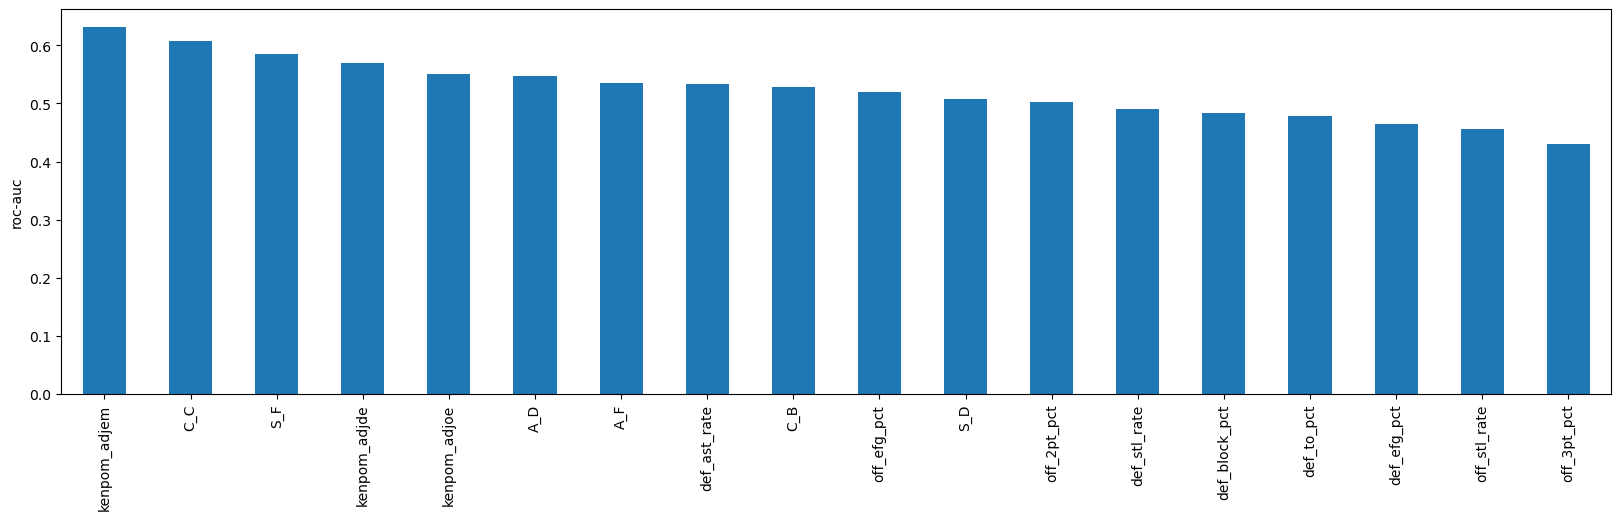

In [93]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [94]:
len(roc_values[roc_values > 0.5])

12

In [95]:
len(roc_values[roc_values > 0.6])

2

In [97]:
roc_values[roc_values > 0.5]

kenpom_adjem   0.6308
kenpom_adjoe   0.5505
kenpom_adjde   0.5701
off_efg_pct    0.5192
off_2pt_pct    0.5027
def_ast_rate   0.5335
S_D            0.5071
S_F            0.5857
A_D            0.5475
A_F            0.5343
C_B            0.5277
C_C            0.6077
dtype: float64

### V. Exhaustive Feature Selection

In [100]:
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled2 = X_train_scaled[[
 'kenpom_adjem',
 'kenpom_adjoe',
 'kenpom_adjde',
 'off_efg_pct',
 'def_to_pct',
 'off_2pt_pct',
 'off_3pt_pct',
 'def_block_pct',
 'off_stl_rate',
 'def_ast_rate',
 'def_stl_rate',
 'S_D',
 'S_F',
 'A_D',
 'A_F',
 'C_B',
 'C_C'
]]

X_test_scaled2 = X_test_scaled[[
 'kenpom_adjem',
 'kenpom_adjoe',
 'kenpom_adjde',
 'off_efg_pct',
 'def_to_pct',
 'off_2pt_pct',
 'off_3pt_pct',
 'def_block_pct',
 'off_stl_rate',
 'def_ast_rate',
 'def_stl_rate',
 'S_D',
 'S_F',
 'A_D',
 'A_F',
 'C_B',
 'C_C'
]]

In [102]:
# Initialize variables to track the best model
log_reg = LogisticRegression(solver='liblinear')
best_f1 = 0
best_features = []
best_train_f1 = 0

# Iterate over all possible subsets of features
for k in range(1, len(X_train_scaled2.columns) + 1):
    for subset in combinations(X_train_scaled2.columns, k):
        X_train_subset = X_train_scaled2[list(subset)]
        X_test_subset = X_test_scaled2[list(subset)]
        
        # Train the model with the subset of features
        log_reg.fit(X_train_subset, y_train)
        
        # Make predictions on the test set
        y_test_pred = log_reg.predict(X_test_subset)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Make predictions on the training set
        y_train_pred = log_reg.predict(X_train_subset)
        train_f1 = f1_score(y_train, y_train_pred)
        
        # Track the best subset based on test F1 score
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_features = subset
            best_train_f1 = train_f1

# Output the best feature subset and the F1 scores
print(f"Best Feature Subset: {best_features}")
print(f"Best Test F1 Score: {best_f1:.4f}")
print(f"Training F1 Score of Best Model: {best_train_f1:.4f}")

Best Feature Subset: ('kenpom_adjem', 'off_efg_pct', 'off_2pt_pct', 'off_3pt_pct', 'def_block_pct', 'def_ast_rate', 'def_stl_rate', 'S_D', 'S_F', 'A_F', 'C_B')
Best Test F1 Score: 0.8679
Training F1 Score of Best Model: 0.8329
